## This notebook shows the steps in slowly converting the [Bundle IVP example](https://colab.research.google.com/drive/1L9NGeLoDONWmCr_tZkjIJziF3yo1OJHE?usp=sharing) to the current (extremely simplified) version of the radiation transport equation.

In [2]:
# Standard imports applicable to all examples

import matplotlib.pyplot as plt
import numpy as np
import neurodiffeq
from neurodiffeq.solvers import BundleSolver1D
from neurodiffeq.conditions import BundleIVP
from neurodiffeq import diff

neurodiffeq.utils.set_tensor_type('cpu')

%matplotlib inline

/home/marko.ristic/p3venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/marko.ristic/p3venv/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Example 1: Direct Bundle IVP example

Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.51it/s]


Text(0, 0.5, 'u')

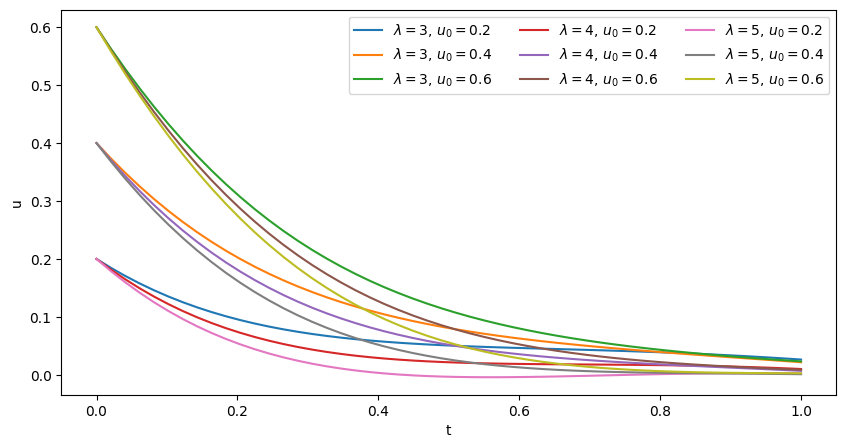

In [4]:
T_MIN, T_MAX = 0, 1
LAMBDA_MIN,  LAMBDA_MAX = 3, 5
U0_MIN, U0_MAX = 0.2, 0.6

diff_eq = lambda u, t, lmd: [diff(u, t) + lmd * u]

conditions = [
    BundleIVP(t_0=0, u_0=None, bundle_param_lookup={'u_0': 1})   # we refer to u_0 as parameter 1; correspondingly lambda will be parameter 0 below
]

solver = BundleSolver1D(
    ode_system=diff_eq,
    conditions=conditions,
    t_min=T_MIN,
    t_max=T_MAX, 
    theta_min=[LAMBDA_MIN, U0_MIN],  # 0: lambda, 1: u_0
    theta_max=[LAMBDA_MAX, U0_MAX],  # 0: lambda, 1: u_0
    eq_param_index=(0,),  # we refer to lambda as parameter 0; correspondingly u_0 is parameter 1 (as in conditions above)
    n_batches_valid=1,
)

solver.fit(max_epochs=1000)
solution = solver.get_solution(best=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

t = np.linspace(0, 1)

for i, lmd_value in enumerate([3, 4, 5]):
    for j, u0_value in enumerate([0.2, 0.4, 0.6]):
        lmd = lmd_value * np.ones_like(t)
        u0 = u0_value * np.ones_like(t)

        u = solution(t, lmd, u0, to_numpy=True)  # network solution takes in three inputs
        ax.plot(t, u, label=f'$\\lambda={lmd_value}$, $u_0={u0_value}$')

ax.legend(ncol=3)
ax.set_xlabel('t')
ax.set_ylabel('u')

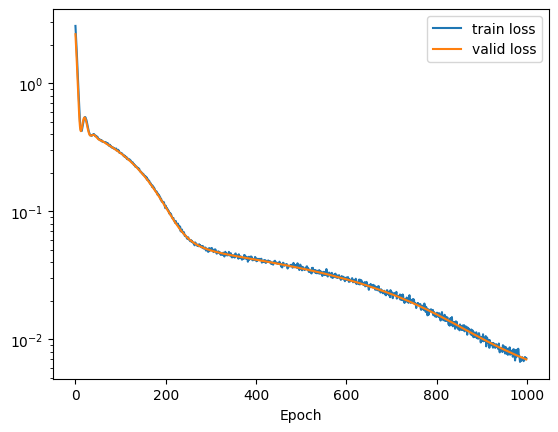

In [5]:
plt.plot(solver.metrics_history['train_loss'], label='train loss')
plt.plot(solver.metrics_history['valid_loss'], label='valid loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()

## Example 2: Refactoring the form of the ODE

Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.96it/s]


Text(0, 0.5, 'u')

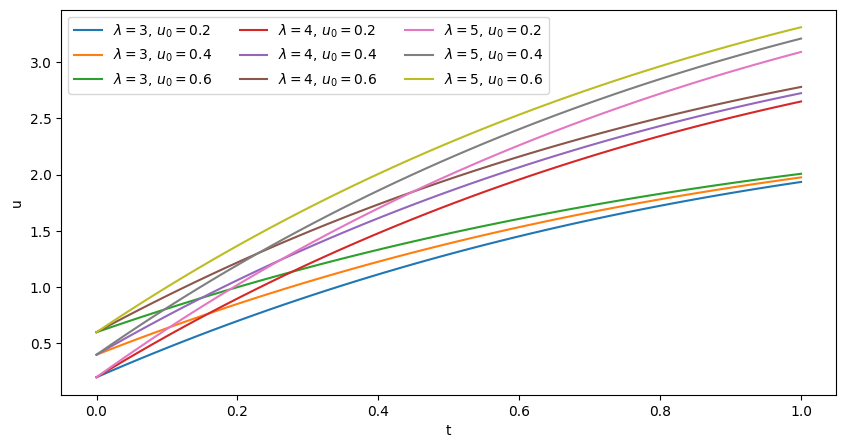

In [6]:
T_MIN, T_MAX = 0, 1
LAMBDA_MIN,  LAMBDA_MAX = 3, 5
U0_MIN, U0_MAX = 0.2, 0.6

diff_eq = lambda u, t, lmd: [-u - diff(u, t) + lmd]

conditions = [
    BundleIVP(t_0=0, u_0=None, bundle_param_lookup={'u_0': 1})   # we refer to u_0 as parameter 1; correspondingly lambda will be parameter 0 below
]

solver = BundleSolver1D(
    ode_system=diff_eq,
    conditions=conditions,
    t_min=T_MIN,
    t_max=T_MAX, 
    theta_min=[LAMBDA_MIN, U0_MIN],  # 0: lambda, 1: u_0
    theta_max=[LAMBDA_MAX, U0_MAX],  # 0: lambda, 1: u_0
    eq_param_index=(0,),  # we refer to lambda as parameter 0; correspondingly u_0 is parameter 1 (as in conditions above)
    n_batches_valid=1,
)

solver.fit(max_epochs=1000)
solution = solver.get_solution(best=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

t = np.linspace(0, 1)

for i, lmd_value in enumerate([3, 4, 5]):
    for j, u0_value in enumerate([0.2, 0.4, 0.6]):
        lmd = lmd_value * np.ones_like(t)
        u0 = u0_value * np.ones_like(t)

        u = solution(t, lmd, u0, to_numpy=True)  # network solution takes in three inputs
        ax.plot(t, u, label=f'$\\lambda={lmd_value}$, $u_0={u0_value}$')

ax.legend(ncol=3)
ax.set_xlabel('t')
ax.set_ylabel('u')

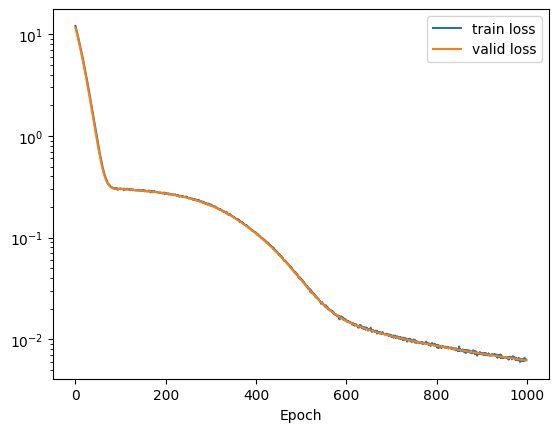

In [7]:
plt.plot(solver.metrics_history['train_loss'], label='train loss')
plt.plot(solver.metrics_history['valid_loss'], label='valid loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()

### Test Case: Does this solution recover the behavior of $e^{-1} \approx 0.36$? We test by expanding the training limits for u<sub>0</sub> and $\Lambda$.

Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.64it/s]


Text(0, 0.5, 'u')

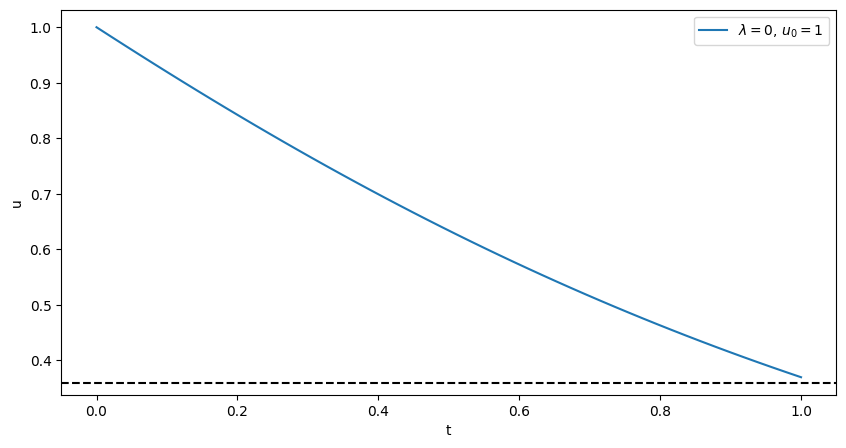

In [21]:
T_MIN, T_MAX = 0, 1
LAMBDA_MIN,  LAMBDA_MAX = -5, 5
U0_MIN, U0_MAX = 0.2, 5

diff_eq = lambda u, t, lmd: [-u - diff(u, t) + lmd]

conditions = [
    BundleIVP(t_0=0, u_0=None, bundle_param_lookup={'u_0': 1})   # we refer to u_0 as parameter 1; correspondingly lambda will be parameter 0 below
]

solver = BundleSolver1D(
    ode_system=diff_eq,
    conditions=conditions,
    t_min=T_MIN,
    t_max=T_MAX, 
    theta_min=[LAMBDA_MIN, U0_MIN],  # 0: lambda, 1: u_0
    theta_max=[LAMBDA_MAX, U0_MAX],  # 0: lambda, 1: u_0
    eq_param_index=(0,),  # we refer to lambda as parameter 0; correspondingly u_0 is parameter 1 (as in conditions above)
    n_batches_valid=1,
)

solver.fit(max_epochs=1000)
solution = solver.get_solution(best=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lmd_value = 0
u0_value = 1

lmd = lmd_value * np.ones_like(t)
u0 = u0_value * np.ones_like(t)

u = solution(t, lmd, u0, to_numpy=True)  # network solution takes in three inputs
ax.plot(t, u, label=f'$\\lambda={lmd_value}$, $u_0={u0_value}$')
ax.axhline(0.36, ls='--', c='k')

ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('u')

### Looks good! Now, let's give some physicality to our parameters: $t$ -> $\tau$ (optical depth), $\Lambda$ -> $S_\lambda$ (the source function, in this case the log of the Planck function), $U_0$ -> $I_0$ (our initial radiation intensity). 

### We set our limits for $I_0$ to be scalar multiples of $S_\lambda$ for our given wavelength $\lambda = 500$ nm. 

### The range of [LAMBDA_MIN, LAMBDA_MAX] is between $\log_{10} 4000$ and $\log_{10} 7000$ Angstroms -- 400-700 nm, approximately the range of the visible spectrum.

In [45]:
# Let's avoid unit conversion mistakes and use a standardized blackbody function from Astropy

import math, torch
from astropy.modeling.models import BlackBody
from astropy import units as unit
from neurodiffeq.networks import FCNN

def to_numpy(x):
    ''' helper function to convert PyTorch tensor to NumPy array '''
    return x.detach().cpu().numpy()

def S_lam(wav):
    wav = 10**wav # undo log10
    try:
        if wav.dtype == torch.float32: wav = to_numpy(wav)
    except: 
        pass
    wav = wav*unit.AA
    S_lambda = BlackBody(temperature=5800*unit.K, scale=1*unit.erg / (unit.cm**2 * unit.s * unit.AA * unit.sr))
    S_lambda = S_lambda(wav)
    return torch.log10(torch.Tensor([S_lambda.value]))

TAU_MIN, TAU_MAX = 0, 10

#-- We change the limits of \lambda to be between 400 and 700 nm, in log-space
LAMBDA_MIN, LAMBDA_MAX = math.log10(4000), math.log10(7000)

#-- We change the limits of I_0 to be scalar multiples of S_lam
#-- This requires a wavelength input, so let's use 550 nm for now
I0_MIN, I0_MAX = 0.1*S_lam(math.log10(5500)), 10*S_lam(math.log10(5500))

print(I0_MIN[0], I0_MAX[0])

diff_eq = lambda I, t, lmd: [-I - diff(I, t) + S_lam(lmd)]

conditions = [
    BundleIVP(t_0=0, u_0=None, bundle_param_lookup={'u_0': 1})   # we refer to u_0 as parameter 1; correspondingly lambda will be parameter 0 below
]

nets = [
    FCNN(n_input_units=3, hidden_units=(512,), n_output_units=1, actv=torch.nn.LeakyReLU)
]

solver = BundleSolver1D(
    ode_system=diff_eq,
    conditions=conditions,
    t_min=TAU_MIN,
    t_max=TAU_MAX, 
    theta_min=[LAMBDA_MIN, I0_MIN[0]],  # 0: lambda, 1: u_0
    theta_max=[LAMBDA_MAX, I0_MAX[0]],  # 0: lambda, 1: u_0
    eq_param_index=(0,),  # we refer to lambda as parameter 0; correspondingly u_0 is parameter 1 (as in conditions above)
    n_batches_valid=1,
)

solver.fit(max_epochs=2000)
solution = solver.get_solution(best=True)

tensor(0.6420) tensor(64.2013)


Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:17<00:00,  7.76it/s]


### Now let's check if these solutions make sense: as $\tau$ -> $\infty$, we expect the solution to converge to $S_\lambda$. We can test this with an upper- and lower-limit $I_0$: $I_0 = 0.2 S_\lambda$ and $I_0 = 5S_\lambda$.

Text(0, 0.5, 'I')

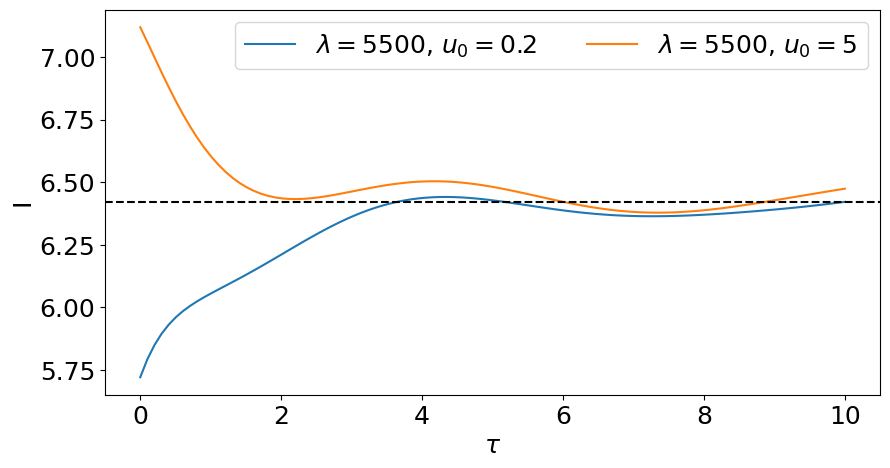

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

t = torch.linspace(0, 10, steps=100)

for i, lmd_value in enumerate([5500]):
    for j, u0_value in enumerate([0.2, 5]):
        lmd = math.log10(lmd_value) * torch.ones_like(t)
        u0 = np.log10(u0_value)+S_lam(torch.log10(torch.tensor([lmd_value]))) * torch.ones_like(t)

        u = solution(t, lmd, u0, to_numpy=True)  # network solution takes in three inputs
        ax.plot(t, u, label=f'$\\lambda={lmd_value}$, $u_0={u0_value}$')
ax.axhline(S_lam(torch.log10(torch.tensor([5500]))), c='k', ls='--')
ax.legend(ncol=2)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('I')

### It (kind of) works! Our solution converges to $\log S_\lambda$ as $\tau$ -> $\infty$. There is some unexplained behavior at $\tau$ > 6 for the orange curve. However, this is farther than I've gotten before, so let's check the actual spectra.

### For the next step, we want to check if the answer converges in the same manner for a vector of wavelengths $\vec{\lambda}$ rather than just a single scalar wavelength i.e. the evolution of a spectrum as a function of optical depth.

Text(0, 0.5, '$\\log_{10} I_\\nu$')

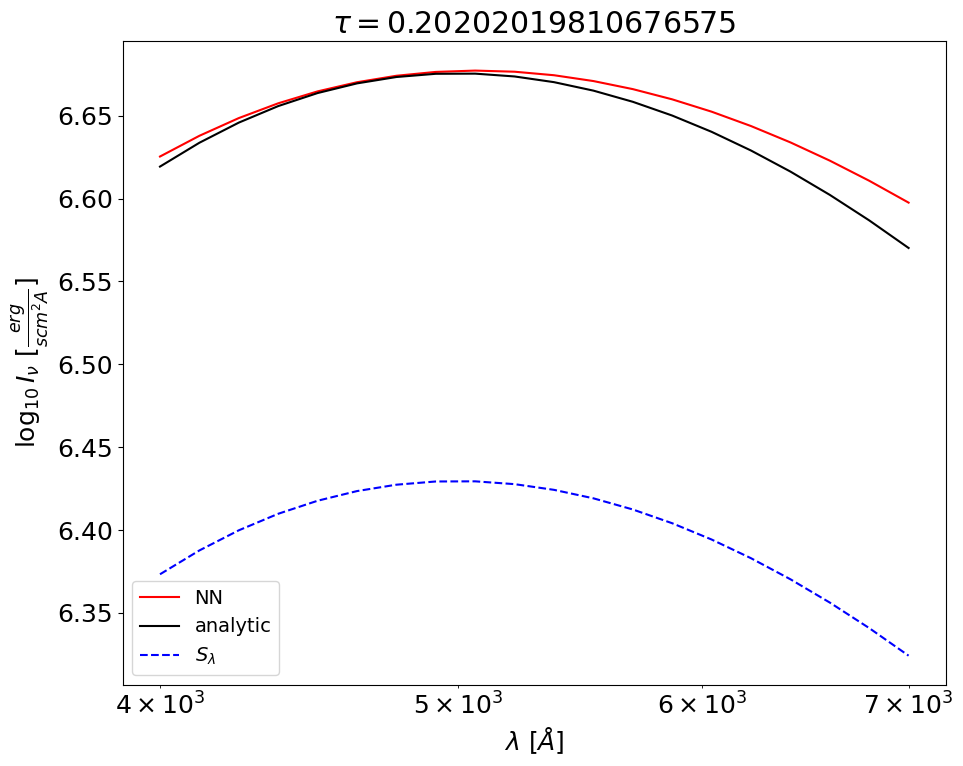

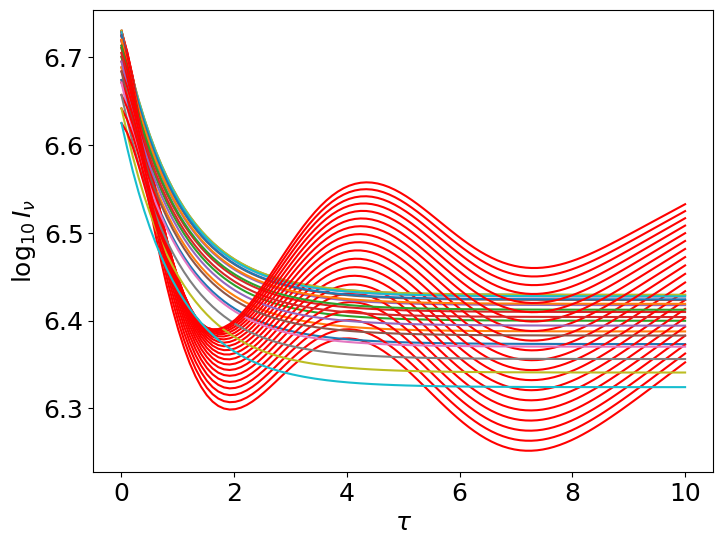

In [48]:
from scipy.integrate import simpson

# Convert our scalar wavelength to a vector of 20 wavelengths

wav = np.logspace(np.log10(4000), np.log10(7000), 20)

## Define our analytic solution for a blackbody source function starting at some intensity I_0 = 2*S_\lambda

# Physical constants

h = 6.626e-27 # cm^2 g s^-1
c = 2.9979e10 # cm/s
k = 1.3807e-16 # cm^2 g s^-2 K^-1

# Analytic blackbody function calculation

wav_analytic = np.logspace(np.log10(4000), np.log10(7000), len(wav))*1e-8 # 1000 to 100,000 Angstroms (100 nm to 10 microns) in units of cm
T = 5800 # temperature, in Kelvin
S_lam_analytic = (2*h*c**2/wav_analytic**5) * 1/(np.exp(h*c/(wav_analytic*k*T)) - 1) # erg / s / cm2 / cm
S_lam_analytic *= 1e-8 # erg / s / cm2 / cm to erg / s / cm2 / A

# Initial condition

I_0 = 2*S_lam_analytic # intensity at r=0

I_0, S_lam_analytic = np.log10(I_0), np.log10(S_lam_analytic)

taus = torch.linspace(0, 10, 100)
I_nu = np.zeros((len(taus), len(wav)))

for j in range(len(wav_analytic)):
    for i in range(len(taus)):
        I_nu[i, j] = simpson(S_lam_analytic[j]*np.exp(-(taus[i] - taus[:i+1])), x=taus[:i+1]) \
        + I_0[j]*np.exp(-taus[i])

I_nu_nn = np.zeros((len(taus), len(wav)))

for l, lmd_value in enumerate(wav):
    lmd = math.log10(lmd_value) * torch.ones_like(t)
    u0 = np.log10(2)+S_lam(torch.log10(torch.tensor([lmd_value]))) * torch.ones_like(t)
    #u0_value = to_numpy(np.log10(2)+S_lam(lmd_value))
    #lmd = to_numpy(lmd_value) * np.ones_like(R)
    #u0 = u0_value * np.ones_like(taus)
    I_nu_nn[:, l] = solution(taus, lmd, u0, to_numpy=True)  # network solution takes in three inputs

plt.rc('font', size=18)
tau_idx = np.argmin(np.abs(taus-0.2))
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(wav, I_nu_nn[tau_idx, :], c='r', label='NN')
ax.plot(wav, I_nu[tau_idx, :], c='k', label='analytic')
ax.plot(wav_analytic*1e8, S_lam_analytic, c='blue', ls='--', label=r'$S_\lambda$') # source function reference
ax.set_title(r'$\tau = {}$'.format(taus[tau_idx]))
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda \ [\AA]$')
ax.set_ylabel(r'$\log_{10} I_\nu \ [\frac{erg}{s cm^2 A}]$')
#ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.0f'))
plt.legend(fontsize=14)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(I_nu.shape[1]):
    ax.plot(taus, I_nu_nn[:, i], c='r')
    ax.plot(taus, I_nu[:, i], label=wav[i])
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\log_{10} I_\nu$')
#plt.legend()
#ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.0f'))
#plt.savefig('I_vs_tau.png')
